This notebook contains a code which aims at building a multilinear regression model for bitcoin price. The collected variables are as follows:
- WTI oil price [USD] 
- SP500 index value 
- Gold price [USD] 
- Number of bitcoin transactions (on the Coinbase market) 
- Volume of bitcoin on the Coinbase market (number of traded bitcoins on a given day)
- M2 money supply in the USA [USD] 
- Time period for the data is between 12.2014 and 04.2020

The main idea behind this project was to check if there are any price connections between bitcoin and other mainly market assets. Two other factors like number of bitcoin transactions and bitcoin volume (on the Coinbase market) were taken into account.

The project proceeded in four steps:
1. Data preparation (choosing the proper time period, selecting relevant predictors, graphical examination)
2. Building different models (selecting different number of predictors)
3. Evaluation of models and choosing the best one
4. Error evaluation and conclusion

### Loading the dataset. The dataset is created by the author, more details can be found in the raw_data folder.

In [302]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('max_colwidth', 100)

In [303]:
data=pd.read_csv('BTC_regression_data.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')

### Values changes in time

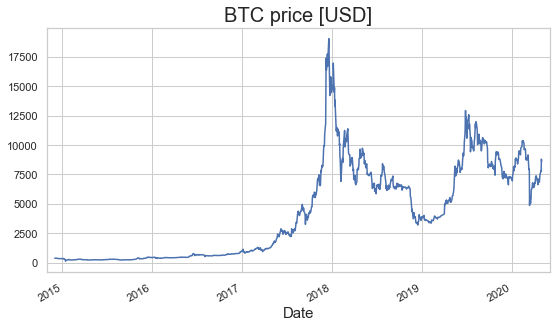

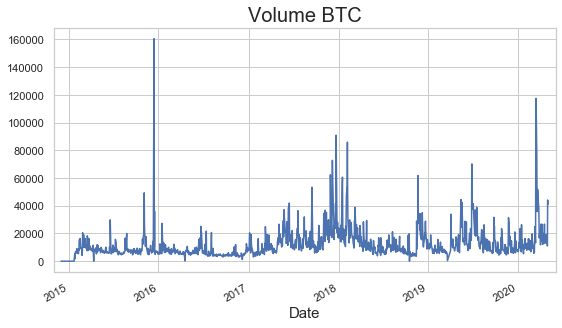

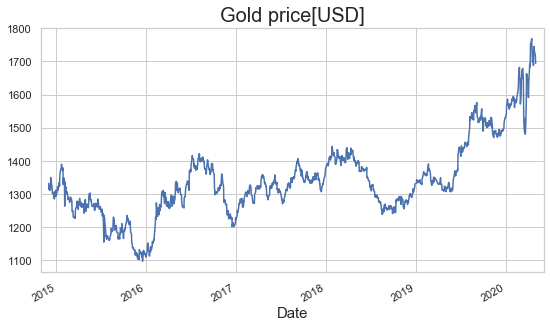

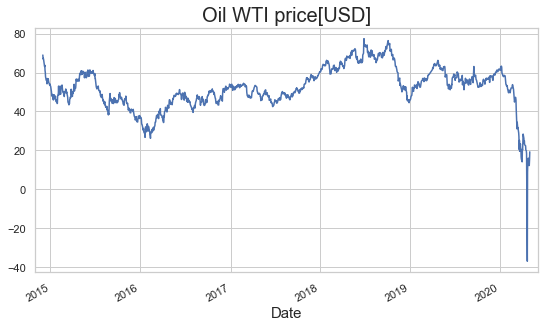

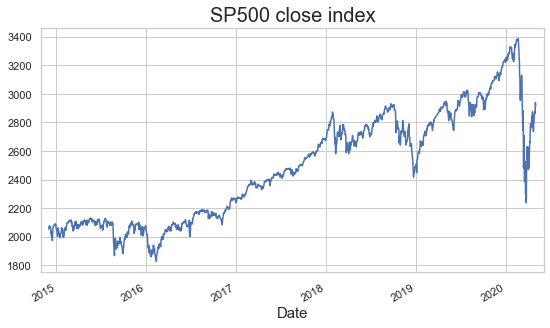

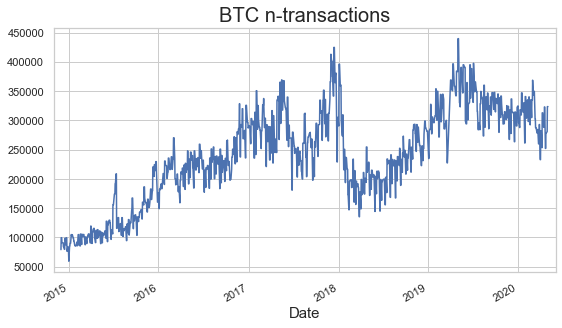

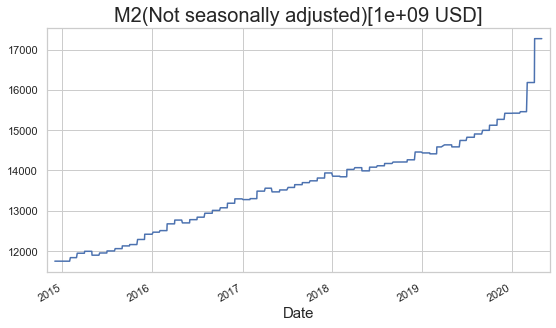

In [304]:
%matplotlib inline

datemin = datetime.date(data.index.min().year, data.index.min().month - 1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 2, 1)
sns.set(style="whitegrid", color_codes=True)

for i in data.columns:

    fig,ax = plt.subplots(figsize=(9,5))      
    data[i].plot(ax=ax)
    plt.gcf().autofmt_xdate()
    ax.set_title(i,fontsize=20)
    ax.set_xlabel('Date',fontsize=15)
    ax.set_xlim([datemin,datemax])
    plt.show()

From the above plots one can infere that bitcoin was not a popular asset until mid-2017. Additionally covid19 pandemic in 2020 caused some unusual action on the market (negative WTI Oil price, huge increase in M2 supply). The last thing worth to mention is that the last bitcoin halving took place in May 2020 - this could be the event that pumped the price.  <br> For the above reasons the time period was limited to 05.2017 - 02.2020 ( _data2_ dataframe)

In [324]:
data2=data.copy()
date_mask = (data2.index > pd.to_datetime('2017-05-01')) & (data2.index < pd.to_datetime('2020-02-01'))
data2 = data2[date_mask]

In [306]:
data2.head()

,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index,BTC n-transactions,M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,
2017-05-02,1471.99,11924.59,1324.0,47.65,2391.169922,333161.0,13467.3
2017-05-03,1533.00,16309.77,1315.5,47.79,2388.129883,333161.0,13467.3
2017-05-04,1563.39,26688.81,1295.3,45.55,2389.520020,333161.0,13467.3
2017-05-05,1551.30,16885.42,1293.7,46.23,2399.290039,267193.0,13467.3
2017-05-08,1713.00,15881.13,1294.0,46.46,2399.379883,365096.0,13467.3


### Graphical examination of the relationship between bitcoin price and the other features

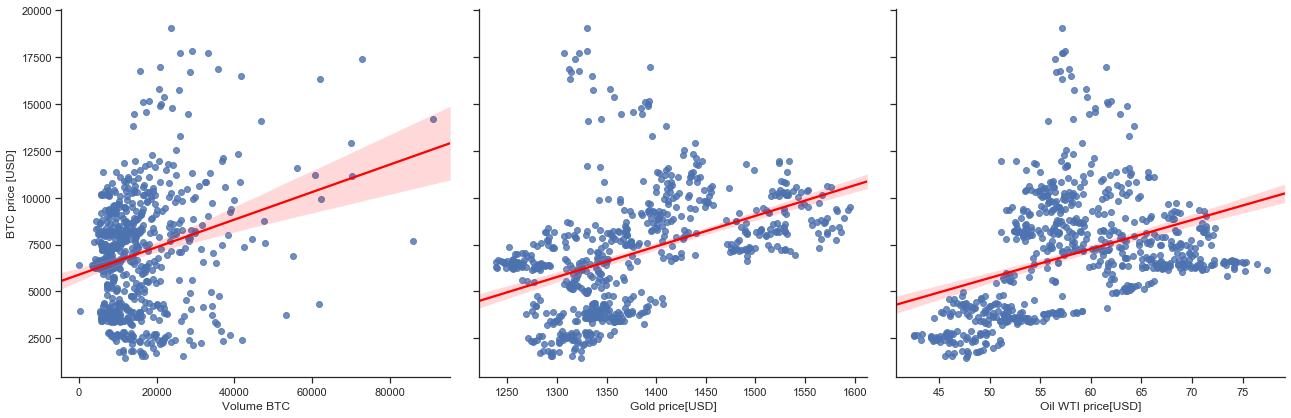

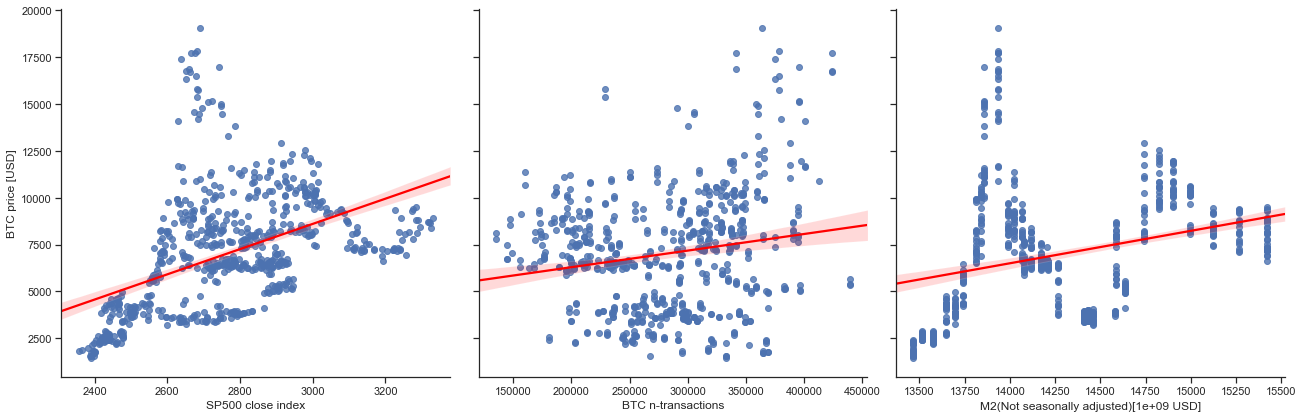

In [307]:
sns.set(style="ticks", color_codes=True)
for i in range(1,len(data2.columns),3):
    g = sns.PairGrid(data2,y_vars='BTC price [USD]',x_vars=data2.columns[i:i+3],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})

The above plots suggest that there hardly is any connection between bitcoin price and number of transactions. This variable is removed. Relationship between bitcoin price and bitcoin volume is questionable, but this variable is kept for the sake of curiosity.

In [308]:
data2.drop(columns=['BTC n-transactions'],inplace=True)

### The author checked if it is possible to obtain more linear relationship using the transformations like $ ln(X), X^2, \sqrt{X} $ but it did not help. The $ \sqrt{X} $ transoformation is shown below

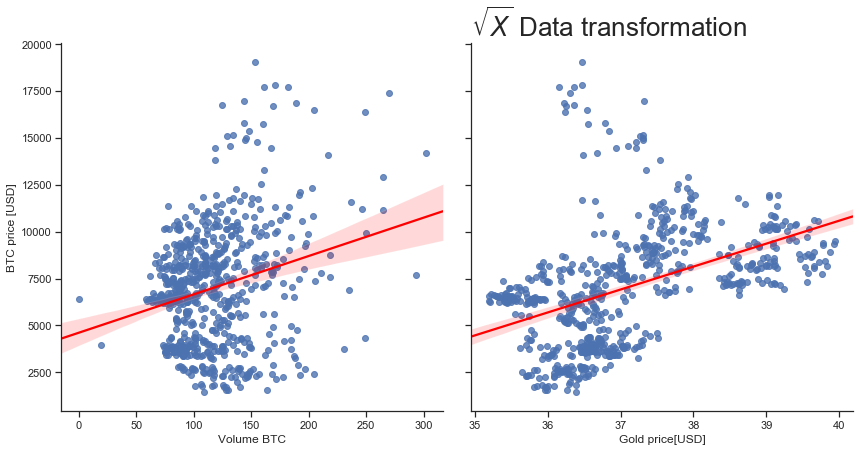

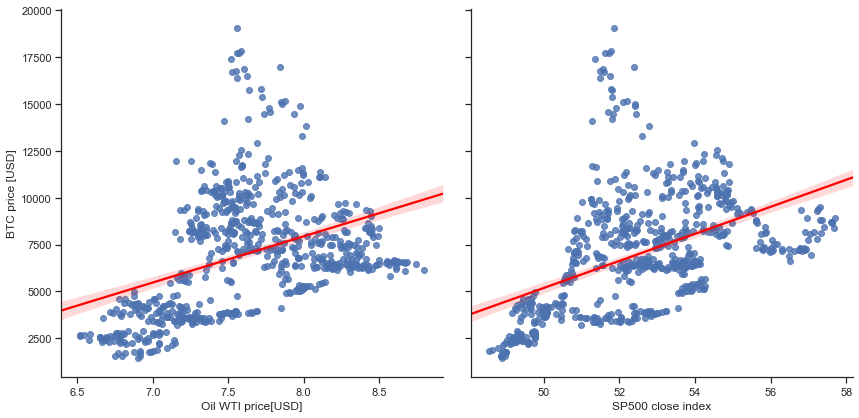

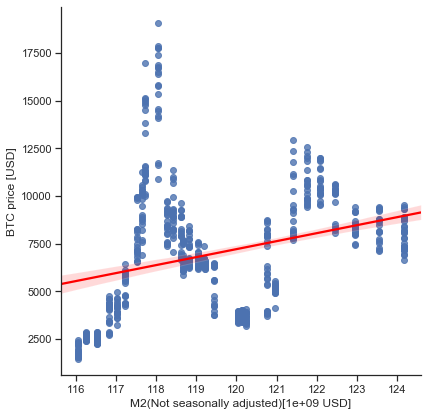

In [309]:
data_sqrt=data2.copy()
data_sqrt.iloc[:,1:]=data_sqrt.iloc[:,1:].apply(lambda x: np.sqrt(x))
s=2
for i in range(1,len(data_sqrt.columns),s):   
    g = sns.PairGrid(data_sqrt,y_vars='BTC price [USD]',x_vars=data_sqrt.columns[i:i+s],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})
    if i==1:
        plt.title('$\sqrt{X}$ Data transformation ',fontsize=26,loc='left')

### Before proceeding further the correlation matrices and VIF are evaluated in order to exclude multicollinearity

In [310]:
def corr_matrix(dataset,dataname=' '):
    fig,ax = plt.subplots(figsize=(6,6))
    ax= sns.heatmap(dataset.corr(),vmin=0,vmax=1,annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title('correlation matrix for {}'.format(i))

def vif(dataset):
    X=dataset.drop(columns=['BTC price [USD]'])    
    X=sm.add_constant(X)
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns).iloc[1:]


VIF for  data2
Volume BTC                                1.188639
Gold price[USD]                           2.120687
Oil WTI price[USD]                        2.636350
SP500 close index                         9.995985
BTC n-transactions                        1.636495
M2(Not seasonally adjusted)[1e+09 USD]    8.406989
dtype: float64


variables with large (>5) VIF:
 SP500 close index                         9.995985
M2(Not seasonally adjusted)[1e+09 USD]    8.406989
dtype: float64
 


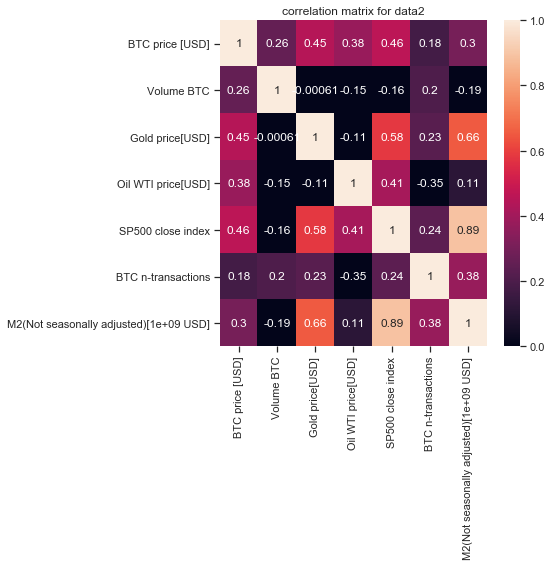

In [325]:
data_list=['data2']
for i in data_list:
    print('\nVIF for ',i)
    ds=vif(eval(i))
    print(ds)
    print("\n")
    print('variables with large (>5) VIF:\n',ds[ds>5] )
    print(" ")
    corr_matrix(eval(i),i)

### Correlation between independent variables

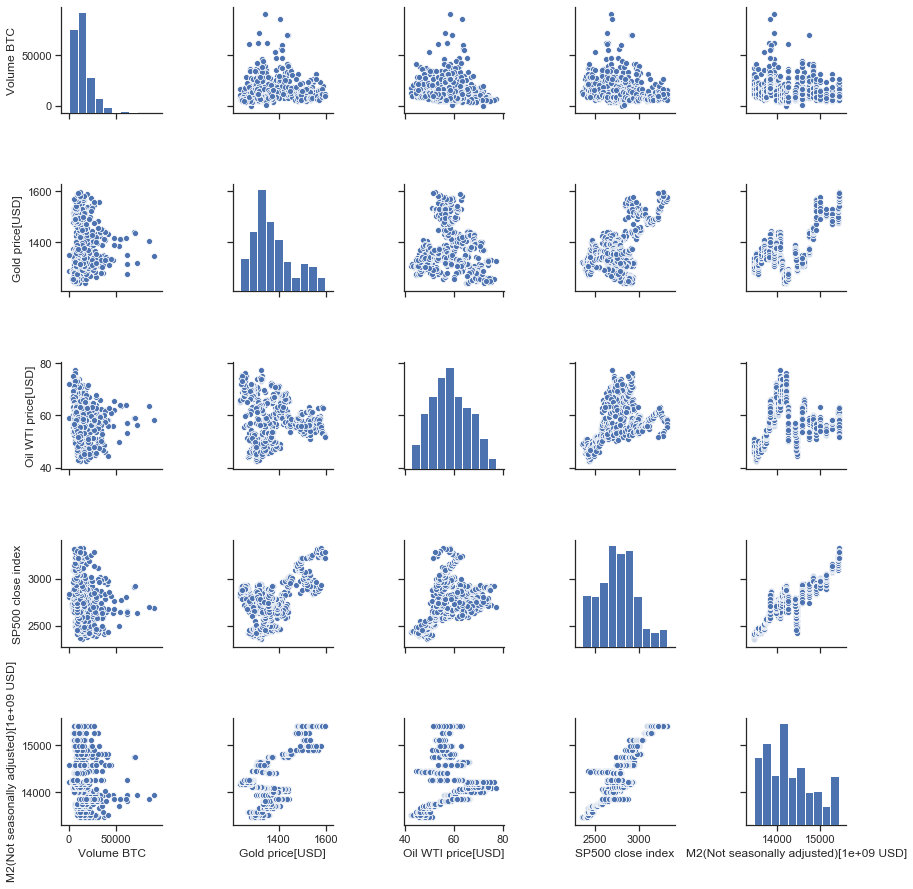

In [312]:
sns.pairplot(data2.drop(columns=['BTC price [USD]']))

M2 and SP500 index are highly correlated. Because there is no noticable relationship between bitcoin price and M2 money supply the latter one is removed.

In [313]:
data2.drop(columns=['M2(Not seasonally adjusted)[1e+09 USD]'],inplace=True)

The final dataset is in the following form

In [314]:
data2.head()

,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index
Date,,,,,
2017-05-02,1471.99,11924.59,1324.0,47.65,2391.169922
2017-05-03,1533.00,16309.77,1315.5,47.79,2388.129883
2017-05-04,1563.39,26688.81,1295.3,45.55,2389.520020
2017-05-05,1551.30,16885.42,1293.7,46.23,2399.290039
2017-05-08,1713.00,15881.13,1294.0,46.46,2399.379883


### Multilinear regression

The final dataset is split into train (85% values) and test data (15% values)

In [315]:
X_train, X_test, y_train, y_test = train_test_split(data2.drop(columns=['BTC price [USD]']),data2['BTC price [USD]'], train_size=0.85, random_state=1)

### Having kept four predictors $ \binom{4}{1} + \binom{4}{2} + \binom{4}{3} + \binom{4}{4} = 15 $ models are possible. All the models are examinated.

First each model is trained on the train data. Next R-squared value and residual standard error (RSE) are calculated. __Note__: R-squared value is calculated for the train set whereas RSE for the test set.

$$ RSS = ( y_1 - \hat{y_1})^2 + ... + ( y_n - \hat{y_n})^2 $$
$$ RSE = \sqrt{\frac{RSS}{n-p-1}} $$
where: <br>
RSS (resudual sum of squares) - difference between the _i-th_ observed response value and the _i-th_ response value that is predicted <br>
RSE (residual standard error) - a measure of lack of fit of the model <br>
_p_ (degrees of freedom) - number of estimated parameters WITHOUT intercept <br>
_n_ - number of observations

In [316]:
#creating all possible combinations of predictors
from itertools import combinations
comb=[]
for i in range(1,5):
    cols=combinations(data2.columns[1:],i)
    comb.extend(list(cols))

#dataframe for models' parameters    
results_df=pd.DataFrame(columns=['model predictors','Rsquared','RSE'])   
Rsquared_list=[]
RSE_list=[]

#creating and testing 15 models
for i in comb:
    LR=LinearRegression()
    x_train_temp=X_train[list(i)]
    x_test_temp=X_test[list(i)]
    LR.fit(x_train_temp,y_train)
    
    #predicting the results on the test dataset
    y_pred=LR.predict(x_test_temp)
    
    #calculating the parameters
    RSS=((y_test-y_pred)**2).sum()
    RSE=np.sqrt(RSS/(y_test.shape[0]-len(i)))
    R2=r2_score(y_train,LR.predict(x_train_temp))
    
    model_name=str(i).replace("(","").replace(")","").replace("\'","")
    results_df=results_df.append({'model predictors':model_name,'Rsquared':R2,'RSE':RSE},ignore_index=True)

print('the models with the lowest RSE\n',results_df['RSE'].nsmallest(5))
print('the models with the largest r-squared value\n',results_df['Rsquared'].nlargest(5))

idx=results_df['RSE'].nsmallest(5).index.intersection(results_df['Rsquared'].nlargest(5).index)
print('\nthe models with the best parameters are: \n')
results_df.iloc[idx,:]

the models with the lowest RSE
 10    2038.168903
14    2056.587006
7     2243.234855
13    2254.154390
12    2359.693122
Name: RSE, dtype: float64
the models with the largest r-squared value
 14    0.488940
10    0.486770
12    0.386667
13    0.377577
7     0.377568
Name: Rsquared, dtype: float64

the models with the best parameters are: 



,model predictors,Rsquared,RSE
10,"Volume BTC, Gold price[USD], Oil WTI price[USD]",0.486770,2038.168903
14,"Volume BTC, Gold price[USD], Oil WTI price[USD], SP500 close index",0.488940,2056.587006
7,"Gold price[USD], Oil WTI price[USD]",0.377568,2243.234855
13,"Gold price[USD], Oil WTI price[USD], SP500 close index",0.377577,2254.154390
12,"Volume BTC, Oil WTI price[USD], SP500 close index",0.386667,2359.693122


### Further examinations of the top 5 models
In order to calculate p-values for the top 5 models the statsmodel library is used

In [327]:
for i in np.sort(np.array(idx)):
    X_temp=X_train[list(comb[i])]
    X_temp=sm.add_constant(X_temp)
    reg=sm.OLS(y_train,X_temp).fit()
    print(i,'th model with ',comb[i])
    print(reg.summary())
    print('')

7 th model with  ('Gold price[USD]', 'Oil WTI price[USD]')
                            OLS Regression Results                            
Dep. Variable:        BTC price [USD]   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     174.1
Date:                Fri, 22 May 2020   Prob (F-statistic):           8.03e-60
Time:                        17:00:04   Log-Likelihood:                -5328.8
No. Observations:                 577   AIC:                         1.066e+04
Df Residuals:                     574   BIC:                         1.068e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

The models 13 and 14 are incorrect because of the large p-value (model 13 - SP500, model 14 - SP500). The remaining models are

In [318]:
idx_best=np.array([7,10,12])
results_df.iloc[idx_best]

,model predictors,Rsquared,RSE
7,"Gold price[USD], Oil WTI price[USD]",0.377568,2243.234855
10,"Volume BTC, Gold price[USD], Oil WTI price[USD]",0.486770,2038.168903
12,"Volume BTC, Oil WTI price[USD], SP500 close index",0.386667,2359.693122


The model 10 is the best from the received. The model's parameters are shown below 

In [319]:
X_temp=X_train[list(comb[10])]
X_temp=sm.add_constant(X_temp)
reg=sm.OLS(y_train,X_temp).fit()
reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-3.086e+04,1782.214,-17.318,0.000,-3.44e+04,-2.74e+04
Volume BTC,0.0918,0.008,11.042,0.000,0.075,0.108
Gold price[USD],18.2239,1.124,16.218,0.000,16.017,20.431
Oil WTI price[USD],195.2956,12.495,15.630,0.000,170.754,219.837


## Standard error and error plots for regressions

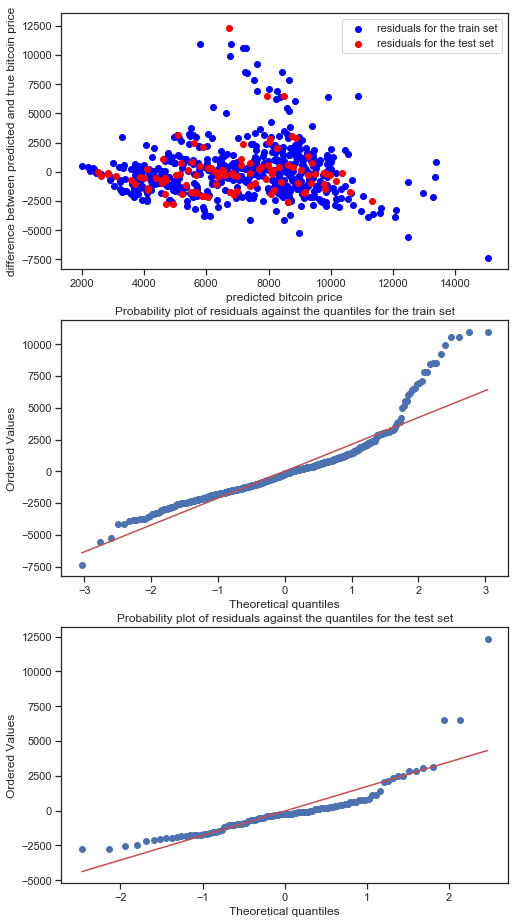

In [320]:
X_tr=X_train[list(comb[10])]
X_te=X_test[list(comb[10])]

LR.fit(X_tr,y_train)
y_pred_train=LR.predict(X_tr)
y_pred_test=LR.predict(X_te)

fig,ax=plt.subplots(nrows=3,figsize=(8,16))
res_train=y_train-y_pred_train
res_test = y_test-y_pred_test
ax[0].scatter(y_pred_train,res_train,c='blue',label='residuals for the train set')
ax[0].scatter(y_pred_test,res_test,c='red',label='residuals for the test set')
ax[0].set(xlabel='predicted bitcoin price', ylabel='difference between predicted and true bitcoin price')
ax[0].legend()

probplot(res_train, dist='norm', fit=True, plot=ax[1], rvalue=False)
ax[1].set_title('Probability plot of residuals against the quantiles for the train set')
probplot(res_test, dist='norm', fit=True, plot=ax[2], rvalue=False)
ax[2].set_title('Probability plot of residuals against the quantiles for the test set')
plt.show()

Predicted price using the best model

In [321]:
price_prediction=pd.DataFrame(columns=['true price','predicted price','difference'])
price_prediction['true price']=y_test
price_prediction['predicted price']=y_pred_test
price_prediction['difference']=res_test
price_prediction.sort_index(inplace=True)
price_prediction.head(30)

,true price,predicted price,difference
Date,,,
2017-05-19,1976.23,4719.331353,-2743.101353
2017-05-30,2191.58,4931.373831,-2739.793831
2017-06-05,2698.00,4121.774367,-1423.774367
2017-06-20,2725.08,3113.519301,-388.439301
2017-06-21,2643.35,2859.336584,-215.986584
2017-06-29,2530.00,2532.007136,-2.007136
2017-07-11,2310.01,2627.641481,-317.631481
2017-07-24,2762.26,2844.370365,-82.110365
2017-07-25,2564.00,4127.865554,-1563.865554


### Summary:
- After rejecting unrelated predictors all possible combinations of remaining predictors were examinated. The models were tested on the test dataset, which was not involved in the fitting process. The best model is the model with three predictors: BTC volume, gold price, oil price.
- Excluding few points the train residuals as well as the test residuals have rather linear pattern which whould suggest that model is correct. However probabilty plot of residuals are not placed along the red line. This indicates that the residuals do not have a normal distribution what suggests that the model is incorrect
- the RSE value is huge. 2000 \\$ is a meaningful fraction of bitcoin price (10\% of the all time high value, whereas over 20\% for today's price (22.05.2020))
- The best received model suggest that oil price is the most meaningful for bitcoin price what does not seem sensible.
- The table with true and predicted price shows that the model can be very wrong (difference like 6000\\$) as well as very precise (2\\$ difference). In general it is not very precise

### The conclusion

- Bitcoin price is not strongly connected with any of the main market assets. 
- It is impossible to build a linear model which would precisly predict the bitcoin price basing on the main market assets 

